In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

tfds.disable_progress_bar()
tf.enable_v2_behavior()

In [2]:
# #S3 path does not work in notebook
# import sagemaker

# sess = sagemaker.Session()
# bucket = sess.default_bucket()

# dataset_path = "s3://{}/{}/".format(bucket, "tensorflow-datasets")
# print(dataset_path)



# (ds_train, ds_test), ds_info = tfds.load(
#     'mnist',
#     split=['train', 'test'],
#     shuffle_files=True,
#     as_supervised=True,
#     data_dir=dataset_path,
#     with_info=True,
# )

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

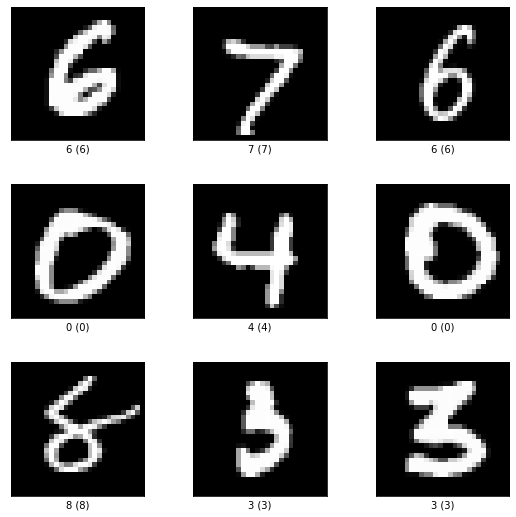

In [4]:
fig = tfds.show_examples(ds_test, ds_info)

In [5]:
ds = ds_train.take(1)

for image, label in ds:
  print(image.dtype, image.shape, label)

for image, label in tfds.as_numpy(ds):
  print(type(image), type(label), label)



<dtype: 'uint8'> (28, 28, 1) tf.Tensor(4, shape=(), dtype=int64)
<class 'numpy.ndarray'> <class 'numpy.int64'> 4


In [6]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

In [7]:
# split begins
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [8]:
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
# split ends

In [ ]:
# before split
# ds_train = ds_train.map(
#     normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_train = ds_train.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
# ds_train = ds_train.batch(128)
# ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

### Build evaluation pipeline

Testing pipeline is similar to the training pipeline, with small differences:

 * No `ds.shuffle()` call
 * Caching is done after batching (as batches can be the same between epoch)

In [9]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
ds = ds_train.take(1)

for image, label in ds:
  print(image.dtype, image.shape, label)

for image, label in tfds.as_numpy(ds):
  print(type(image), type(label), label)

ds = ds_test.take(1)

for image, label in ds:
  print(image.dtype, image.shape, label)

for image, label in tfds.as_numpy(ds):
  print(type(image), type(label), label)

<dtype: 'float32'> (128, 28, 28, 1) tf.Tensor(
[9 2 2 0 7 6 4 7 4 0 0 0 2 7 2 6 2 2 8 1 4 1 1 6 4 3 8 9 2 3 5 4 5 5 1 0 3
 6 0 7 7 1 8 1 2 2 9 8 1 6 3 8 7 3 3 7 6 6 0 3 4 3 0 3 5 5 8 7 4 1 4 4 7 2
 7 2 9 5 2 4 1 1 8 5 8 0 7 6 8 5 6 1 5 3 3 8 4 4 0 1 5 6 2 3 9 1 5 7 6 0 4
 4 2 1 6 6 0 2 1 9 8 0 6 1 8 2 0 8], shape=(128,), dtype=int64)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> [2 1 6 3 6 7 1 6 1 6 9 8 3 5 7 5 0 8 4 6 2 3 8 7 7 4 7 3 7 8 2 1 7 1 9 1 8
 4 3 1 5 0 2 6 0 2 8 2 1 4 0 0 1 2 6 9 5 2 1 0 4 6 3 1 1 2 0 7 7 3 3 2 8 7
 8 6 7 3 1 6 3 8 9 7 6 1 7 5 2 0 2 4 9 8 9 8 9 9 7 7 4 1 1 9 4 6 2 2 1 9 1
 0 3 9 7 7 0 6 6 8 7 7 9 7 8 2 4 5]
<dtype: 'float32'> (128, 28, 28, 1) tf.Tensor(
[8 4 2 7 6 0 6 0 3 1 8 0 7 9 5 4 8 4 3 0 6 6 3 2 0 3 6 6 7 4 9 3 7 8 5 4 5
 2 5 8 5 2 9 2 2 4 7 0 5 1 0 7 9 9 9 6 5 8 8 6 9 9 5 4 2 6 8 1 0 6 9 5 5 4
 1 6 7 5 2 9 0 6 4 4 2 8 7 8 3 0 9 0 1 1 9 4 5 9 7 6 6 0 7 7 8 4 8 8 1 8 0
 2 9 1 0 3 9 7 0 4 9 6 8 9 3 5 4 3], shape=(128,), dtype=int64)
<class 'numpy.ndarr

## Step 2: Create and train the model

Plug the input pipeline into Keras.

In [13]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [14]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(0.001),
    metrics=['accuracy'],
)

In [15]:
model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
)

Epoch 1/10
469/469 [==============================] - 6s 12ms/step - loss: 0.2287 - accuracy: 0.9309 - val_loss: 0.0619 - val_accuracy: 0.9794
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0714 - accuracy: 0.9781 - val_loss: 0.0407 - val_accuracy: 0.9865
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0491 - accuracy: 0.9845 - val_loss: 0.0365 - val_accuracy: 0.9878
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0388 - accuracy: 0.9875 - val_loss: 0.0269 - val_accuracy: 0.9906
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0319 - accuracy: 0.9896 - val_loss: 0.0241 - val_accuracy: 0.9911
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0287 - accuracy: 0.9905 - val_loss: 0.0238 - val_accuracy: 0.9918
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0241 - accuracy: 0.9920 - val_loss: 0.0232 - val_accuracy: 0.9912
Epoch

In [16]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)             

In [17]:
model.save('my_model_v2') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: my_model_v2/assets


INFO:tensorflow:Assets written to: my_model_v2/assets


In [18]:
model.save('my_model_v2.h5') 